In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType

from textblob import TextBlob
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
spark = SparkSession.builder \
    .appName("Flipkart Review Sentiment Analysis") \
    .getOrCreate()

In [8]:
df_spark = spark.read.csv("/content/Flipkart_Reviews - Electronics.csv", header=True, inferSchema=True)

In [24]:
df_sentiment.printSchema()

root
 |-- product_id: string (nullable = true)
 |-- product_title: string (nullable = true)
 |-- rating: integer (nullable = true)
 |-- summary: string (nullable = true)
 |-- review: string (nullable = true)
 |-- location: string (nullable = true)
 |-- date: string (nullable = true)
 |-- upvotes: string (nullable = true)
 |-- downvotes: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [10]:
df_clean = df_spark.filter((df_spark["review"].isNotNull()) & (df_spark["rating"].isNotNull()))

In [11]:
def get_sentiment(text):
    try:
        polarity = TextBlob(text).sentiment.polarity
        if polarity > 0.1:
            return "Positive"
        elif polarity < -0.1:
            return "Negative"
        else:
            return "Neutral"
    except:
        return "Neutral"

sentiment_udf = udf(get_sentiment, StringType())
df_sentiment = df_clean.withColumn("sentiment", sentiment_udf(col("review")))

In [12]:
sentiment_pd = df_sentiment.groupBy("sentiment").count().toPandas()
fig1 = px.pie(sentiment_pd, names="sentiment", values="count", hole=0.4, title="Sentiment Distribution")
fig1.show()

In [21]:
rating_pd = df_sentiment.groupBy("rating").count().orderBy("rating").toPandas()
fig2 = px.pie(rating_pd, names="rating", values="count", hole=0.3, title="Rating Distribution")
fig2.show()
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, round

# Step 1: Start Spark session
spark = SparkSession.builder.appName("RatingSummary").getOrCreate()

# Step 2: Load data
df = spark.read.csv("/content/Flipkart_Reviews - Electronics.csv", header=True, inferSchema=True)

# Step 3: Filter non-null ratings
df = df.filter(col("rating").isNotNull())

# Step 4: Count of each rating
rating_summary = df.groupBy("rating") \
                   .agg(count("*").alias("count"))

# Step 5: Get total number of reviews
total_reviews = df.count()

# Step 6: Add percentage column
rating_summary = rating_summary.withColumn(
    "percentage", round((col("count") / total_reviews) * 100, 2)
)

# Step 7: Show the summary
rating_summary.orderBy("rating").show()


+------+-----+----------+
|rating|count|percentage|
+------+-----+----------+
|     1| 1090|     11.63|
|     2|  308|      3.29|
|     3|  622|      6.64|
|     4| 1959|      20.9|
|     5| 5395|     57.55|
+------+-----+----------+



In [14]:
top_products = df_sentiment.groupBy("product_title").count().orderBy(col("count").desc()).limit(5).toPandas()
fig3 = px.bar(top_products, x="product_title", y="count", color="count", title="Top 5 Reviewed Products")
fig3.show()

In [15]:
df_helpful = df_sentiment.withColumn("helpfulness", col("upvotes") - col("downvotes"))
most_helpful = df_helpful.orderBy(col("helpfulness").desc()).select("product_title", "review", "rating", "helpfulness").limit(5)
most_helpful.show(truncate=False)

+--------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------+-----------+
|product_title                               |review                                                                                                                                                                                                                                                                                                                                                                                              

In [16]:
positive_text = " ".join(df_sentiment.filter(df_sentiment.sentiment == "Positive").select("review").rdd.flatMap(lambda x: x).collect())
negative_text = " ".join(df_sentiment.filter(df_sentiment.sentiment == "Negative").select("review").rdd.flatMap(lambda x: x).collect())

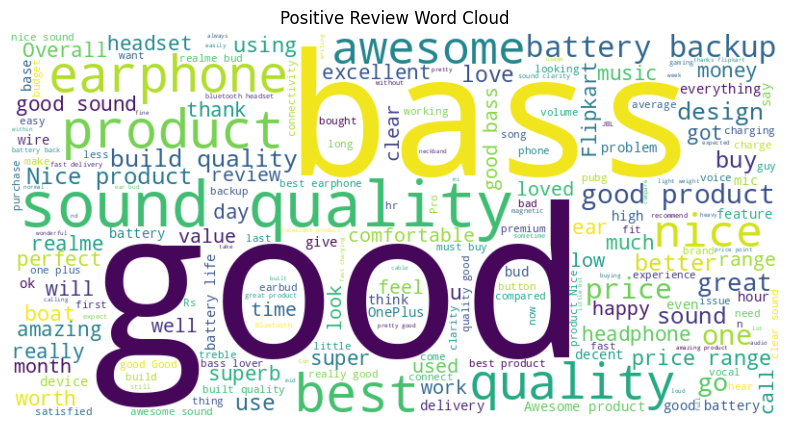

In [17]:
wordcloud_pos = WordCloud(background_color="white", width=800, height=400).generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_pos, interpolation="bilinear")
plt.axis("off")
plt.title("Positive Review Word Cloud")
plt.show()

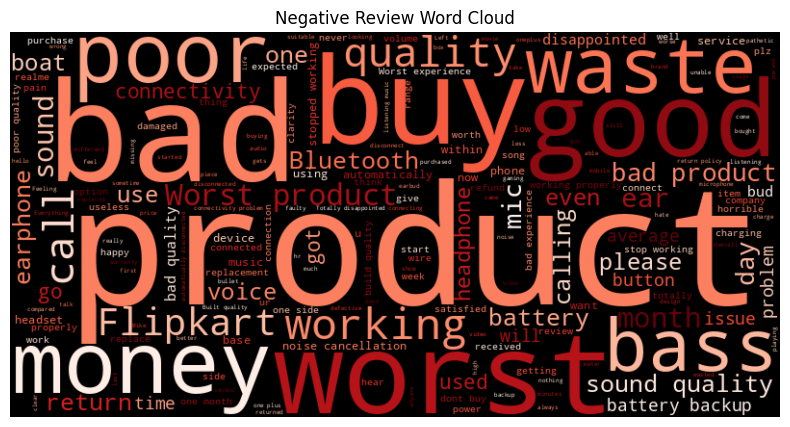

In [23]:
wordcloud_neg = WordCloud(background_color="black", colormap="Reds", width=800, height=400).generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.title("Negative Review Word Cloud")
plt.show()